In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(threshold=np.nan) #Allows for a full printing of databases

#read_and_clean takes in a csv file, turns it into a pandas database,
#removes empty columns, splits complex data into two seperate columns, 
#and removes any data that has 'NaN' as the value
def read_and_clean(fileName):
    data = pd.read_csv(fileName,sep='\t',header=None, nrows = 10000)
    data = data.drop(7, axis=1)
    data = data.replace({'i': 'j'}, regex=True)
    data = data.replace({'\+-': '-'}, regex=True)
    for i in [6,9,10]:
        data[i] = data[i].apply(lambda x: np.complex(x))
        data["real"+str(i)]=data[i].apply(lambda x: np.real(x))
        data["imag"+str(i)]=data[i].apply(lambda x: np.imag(x))
    data = data.dropna()
    return(data)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 

#regress_and_pred creates a database using the read_and_clean 
#function as above, and splits the data into a trainign set
#and a testing set based on timePerc. Then, it runs a random
#forest regression algorithm to predict the values after the
#timePerc value. It outputs the predicted data, the test target,
#and the R-squared value

def regress_and_pred(timePerc,fieldData): #timePerc is a value between 0 and 1
    data = read_and_clean(fieldData)

    train = data[data[0] <= data[0].max(axis=0)*timePerc]
    test = data[data[0] >= data[0].max(axis=0)*timePerc]
    trainIn = train.drop([3,4,5,6,8,9,10,'real6','imag6'], axis=1)
    trainTa = np.ravel(train[[5]])


    testIn = test.drop([3,4,5,6,8,9,10,'real6','imag6'], axis=1)
    testTa = np.ravel(test[[5]])


    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                             RandomForestRegressor(n_estimators=1000))

    hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                      'randomforestregressor__max_depth': [None, 5, 3, 1]}

    clf = GridSearchCV(pipeline, hyperparameters, cv=10)

    clf.fit(trainIn, trainTa)


    pred = clf.predict(testIn)
    R2 = r2_score(testTa, pred)
    return(pred, R2, testTa, trainTa)




In [49]:
#Time_est is a function that runs the regression algorithm
#and adjusts the percentage of data that is split until a 
#certain R-squared value is obtained. 

def time_est(startTimePerc, fieldData, eps, minR2):
    trial = regress_and_pred(startTimePerc, fieldData)
    if trial[1] > minR2:
        print('true')
        print(trial[1])
        return(time_est(startTimePerc-eps, fieldData, eps, minR2))
    else:
        return(trial)

In [ ]:
#An initial test using local data

final = regress_and_pred(20,'/home/cromines/Field_Proj/Field_Data2/print_fields_30.dat')

print(final[1])
print(final[0])
print(final[2])

In [98]:
#An initial test using local data

inter = time_est(1, '/home/cromines/Field_Proj/Field_Data2/print_fields_30.dat', 0.05, 0.85)
p = read_and_clean('/home/cromines/Field_Proj/Field_Data2/print_fields_30.dat')

print(inter[0])

true
0.989702799027
true
0.853482676261
[-14.1081152  -14.1081152  -14.1081152  -14.1081152  -14.1081152
 -14.1081152  -14.1081152  -14.1081152  -14.1081152  -14.1081152
 -14.1081152  -14.1081152  -14.1081152  -14.1081152  -14.1081152
 -14.10813566 -14.1081152  -14.10811514 -14.1081152  -14.11034071
 -14.11034684 -14.11034068 -14.11034686 -14.11034071 -14.11034244
 -14.11034071 -14.11034089 -14.1103406  -14.11034089 -14.11034086
 -14.11034684 -14.11034069 -14.11035111 -14.11035582 -14.11035882
 -14.11034228 -14.11033813 -14.11034063 -14.10761792 -14.10761792
 -14.10761792 -14.10761792 -14.10761792 -14.10761792 -14.10761792
 -14.10761792 -14.10761792 -14.10761792 -14.10761792 -14.10761792
 -14.10761792 -14.1076233  -14.1076192  -14.10765173 -14.10761792
 -14.10761796 -14.10761792 -14.1076181  -14.1076181  -14.1076181
 -14.1076181  -14.1076181  -14.1076181  -14.1076181  -14.1076181
 -14.1076181  -14.1076181  -14.1076181  -14.1076181  -14.1076181
 -14.1076181  -14.10762139 -14.1076181  -1

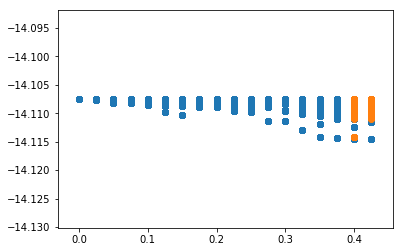

In [123]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

lngPred = np.shape(inter[0])
lngRaw = np.shape(p[5])
plt.scatter(p[0],p[5])
plt.scatter(p.loc[(lngRaw[0]-lngPred[0]):lngRaw[0],0],inter[0])
plt.show()
